#[BIML-Workshop] Pre-trained Models for Transfer Learning(1)-TRANSFORMER



#실습 목표
1. 감정분류 Pretrained 모델을 통한 Transformer에 대해 간단한 코드 실습
2. Pretrained 된 Transformer를 통해 Yelp 리뷰 데이터로 Finetuning 진행




감정 분류 모델에 쓰일 모듈과 사전학습에 쓰일 Yelp 리뷰 데이터를 다운받습니다.

In [ ]:
!pip install transformers datasets
!pip install transformers
!pip install datasets
!pip install evaluate
from datasets import load_dataset
from transformers import AutoTokenizer
dataset = load_dataset("yelp_review_full")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

필요한 모듈을 import 합니다.

In [ ]:
from collections import defaultdict, Counter
import json
from matplotlib import pyplot as plt
import numpy as np
import torch


#사전 학습 전 Transformer에 대한 간단한 실습 진행

# 감정 분류 task를 위한 tokenizer 와 model 구성하기
감정분류 task는 문장을 이진적으로 긍정인지 부정인지 예측합니다.

이에 해당하는 pretrained model을 불러옵니다.

AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

리뷰, 트위터 등 다양한 15개의 데이터 세트에서 텍스트를 추출해서 학습한 감정분석용 pretrained model입니다.



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertTokenizerFast

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased") # convenient! Defaults to Fast

먼저 Token Embedding에서는 두 가지 특수 토큰(CLS, SEP)을 사용하여 문장을 구별.

Special Classification token(CLS)은 모든 문장의 가장 첫 번째(문장의 시작) 토큰
이 토큰은 Classification task에서는 사용되지만, 그렇지 않을 경우엔 무시

Special Separator token(SEP)을 사용하여 첫 번째 문장과 두 번째 문장을 구별.

In [ ]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]
# This is how you call the tokenizer
input_str = "Hugging Face Transformers is great!"
tokenized_inputs = tokenizer(input_str)
def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")


print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

# Two ways to access:
print(tokenized_inputs.input_ids)
# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(input_str)
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print("start:                ", input_str)
print("tokenize:             ", input_tokens)
print("convert_tokens_to_ids:", input_ids)
print("add special tokens:   ", input_ids_special_tokens)
print("--------")
print("decode:               ", decoded_str)

# NOTE that these steps don't create the attention mask or add the special characters


긴 문장의 길이를 맞춰주는 padding 과 sep , cls 토큰 추가 과정을 살펴봅니다.

In [ ]:
model_inputs = tokenizer(["Hugging Face Transformers is great!",
                         "The quick brown fox jumps over the lazy dog." +\
                         "Then the dog got up and ran away because she didn't like foxes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")
print("Padding:")
print_encoding(model_inputs)


Decoding 진행

In [ ]:
print("Batch Decode:")
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print("Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

모델 output 출력해보기

In [ ]:
inputs = "I'm excited to learn about Hugging Face Transformers!"
tokenized_inputs = tokenizer(inputs, return_tensors="pt")
outputs = model(**tokenized_inputs)

labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)

print("Input:")
print(inputs)
print()
print("Tokenized Inputs:")
print_encoding(tokenized_inputs)
print()
print("Model Outputs:")
print(outputs)
print()
print(f"The prediction is {labels[prediction]}")


#Multi head attention Visualize

In [ ]:
from transformers import AutoModel

model_inputs = tokenizer(input_str, return_tensors="pt")
model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)
model_outputs = model(**model_inputs)
model = AutoModel.from_pretrained("distilbert-base-cased", output_attentions=True, output_hidden_states=True)

model.eval()

model_inputs = tokenizer(input_str, return_tensors="pt")
with torch.no_grad():
    model_output = model(**model_inputs)


print("Hidden state size (per layer):  ", model_output.hidden_states[0].shape)
print("Attention head size (per layer):", model_output.attentions[0].shape)


tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)


n_layers = len(model_output.attentions)
n_heads = len(model_output.attentions[0][0])
fig, axes = plt.subplots(6, 12)
fig.set_size_inches(18.5*2, 10.5*2)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer, i].imshow(model_output.attentions[layer][0, i])
        axes[layer][i].set_xticks(list(range(10)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="vertical")
        axes[layer][i].set_yticks(list(range(10)))
        axes[layer][i].set_yticklabels(labels=tokens)

        if layer == 5:
            axes[layer, i].set(xlabel=f"head={i}")
        if i == 0:
            axes[layer, i].set(ylabel=f"layer={layer}")

plt.subplots_adjust(wspace=0.3)
plt.show()

# Transformer 모델 구조

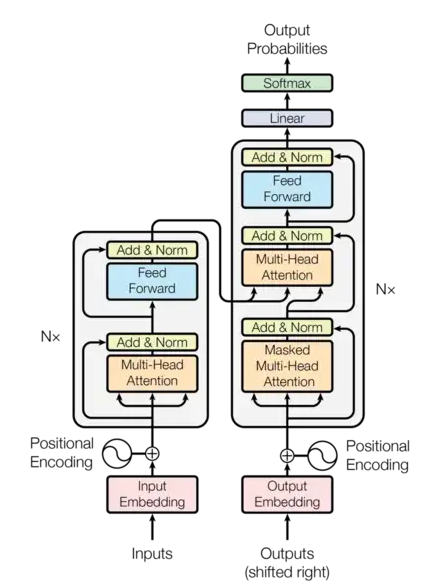

# Yelp 리뷰 데이터로 Fine tuning 진행

Yelp 데이터셋을 활용한다. Yelp 데이터셋은 레스토랑의 리뷰들(Text)를 모아 놓은 데이터 셋입니다.
훈련 샘플 560000개와 테스트샘플 38000개로 나누어져 있다.

라벨은 5개로 1점에서 5점으로 리뷰 평점 값을 의미합니다.

example

label': 0,

"배달 기사가 실수로 133번과 113번을 혼동하여 초인종을 눌렀습니다.\n\n한 걸음 물러서서 상황을 분석하는 대신, 그는 아내와 제가 이 피자를 주문하고 지불을 거부했다고 비난하기 시작합니다.\n\n그런 다음 운전 기사는 주문할 때 제공된 번호로 전화를 걸지 않고 휴대폰을 사용합니다. 그의 상사에게 전화를 걸기 시작하고 중범죄 혐의로 나를 위협하기 시작합니다. \n\n그래서 나는 주도권을 잡고 훌륭한 신사에게 주문자의 전화 번호가 무엇인지 묻고 이웃에게 전화를 걸어 실수를 발견합니다. 고맙거나 미안한 말보다는, 그는 50 피트 떨어진 목적지에 도달하기 위해 속도를 내고 (우리 블록의 제한 속도를 위반했습니다.) \ n \ n 나는 불평하기 위해 전화 할 것이지만, 다른 리뷰에 따르면, 주인은 카네기 또는 그 주민들에 대해 신경 쓰지 않으며, 그들의 음식이 얼마나 끔찍한 지 마을 주변에서 꽤 잘 알려져 있습니다. 그러니 어차피 다시는 주문하지 않을 곳을 보이콧하는 것은 무의미할 것입니다.\n\n마을의 다른 시설에서 호의를 베풀고 주문하십시오."

#Yelp 리뷰 데이터 Tokenized 진행

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Pre trained 된 모델을 불러 옵니다

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

#옵티마이저 및 학습률 스케줄러
옵티마이저와 학습률 스케줄러를 생성

In [ ]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

기본 학습률 스케줄러를 만듭니다.

In [ ]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

마지막으로 GPU에 액세스할 수 있는 경우 GPU를 사용하도록 지정합니다.

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print('')

#Yelp 리뷰데이터를 바탕으로 Transfer learning을 진행합니다



In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

#transfer learning이 끝난 model 평가를 진행합니다

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()